<a href="https://colab.research.google.com/github/vikashnitk/Next-word-prediction-LSTM/blob/main/Next_word_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [4]:
"""
    Dataset: http://www.gutenberg.org/cache/epub/5200/pg5200.txt
    Remove all the unnecessary data and label it as Metamorphosis-clean.
    The starting and ending lines should be as follows.

"""


file = open("/content/drive/MyDrive/ML_projects/next_word_predic_data/metamorphosis_clean.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  ﻿One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


In [5]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:360]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.'

In [6]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'One morning  when Gregor Samsa woke from troubled dreams  he found himself transformed in his bed into a horrible vermin   He lay on his armour like back  and if he lifted his head a little he could see his brown belly  slightly domed and divided by arches into stiff sections   The bedding was hardly able to cover it and seemed ready to slide off any moment   His many legs  pitifully thin compared with the size of the rest of him  waved about helplessly as he looked    What s happened to me   he'

In [8]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room altho'

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('/content/drive/MyDrive/ML_projects/next_word_predic_data/tokenizer.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:5]

[17, 53, 293, 2, 18]

In [22]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [23]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729],
       [729, 135],
       [135, 730],
       [730, 294],
       [294,   8],
       [  8, 731]])

In [24]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [26]:
print("The Data is: ", X[:10])
print("The responses are: ", y[:10])

The Data is:  [ 17  53 293   2  18 729 135 730 294   8]
The responses are:  [ 53 293   2  18 729 135 730 294   8 731]


In [27]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             26170     
_________________________________________________________________
lstm (LSTM)                  (None, 1, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 2617)              2619617   
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


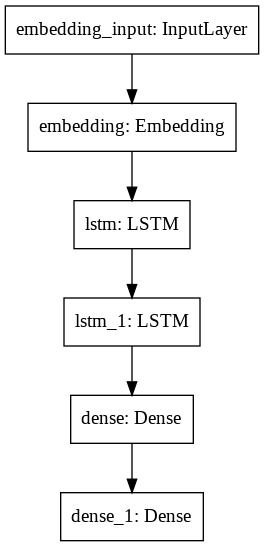

In [30]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='/content/drive/MyDrive/ML_projects/next_word_predic_data/model.png', show_layer_names=True)

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML_projects/next_word_predic_data/nextword.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='/content/drive/MyDrive/ML_projects/next_word_predic_data/logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [32]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [34]:
model.fit(X, y, epochs=100, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/100
61/61 [==============================] - 1s 20ms/step - loss: 7.8606

Epoch 00001: loss improved from 7.87531 to 7.86064, saving model to nextword1.h5
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 7.8149

Epoch 00002: loss improved from 7.86064 to 7.81494, saving model to nextword1.h5
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 7.6342

Epoch 00003: loss improved from 7.81494 to 7.63418, saving model to nextword1.h5
Epoch 4/100
61/61 [==============================] - 1s 11ms/step - loss: 7.4322

Epoch 00004: loss improved from 7.63418 to 7.43220, saving model to nextword1.h5
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 7.2538

Epoch 00005: loss improved from 7.43220 to 7.25382, saving model to nextword1.h5
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 7.1155

Epoch 00006: loss improved from 7.25382 to 7.11553, saving model to nextword1.h5
Epoch 7/100
61/61 [===

In [36]:
model.save('/content/drive/MyDrive/ML_projects/next_word_predic_data/nextword.h5')

In [37]:
# Importing the Libraries

from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer

model = load_model('/content/drive/MyDrive/ML_projects/next_word_predic_data/nextword.h5')
tokenizer = pickle.load(open('/content/drive/MyDrive/ML_projects/next_word_predic_data/tokenizer.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):
    """
        In this function we are using the tokenizer and models trained
        and we are creating the sequence of the text entered and then
        using our model to predict and return the the predicted word.
    
    """
    for i in range(3):
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = np.array(sequence)
        
        preds = model.predict_classes(sequence)

        predicted_word = ""
        
        for key, value in tokenizer.word_index.items():
            if value == preds:
                predicted_word = key
                break
        
        print(predicted_word)
        return predicted_word

In [38]:
"""
    We are testing our model and we will run the model
    until the user decides to stop the script.
    While the script is running we try and check if 
    the prediction can be made on the text. If no
    prediction can be made we just continue.

"""

# text1 = "at the dull"
# text2 = "collection of textile"
# text3 = "what a strenuous"
# text4 = "stop the script"

while(True):

    text = input("Enter your line: ")
    
    if text == "stop the script":
        print("Ending The Program.....")
        break
    
    else:
        try:
            text = text.split(" ")
            text = text[-1]

            text = ''.join(text)
            Predict_Next_Words(model, tokenizer, text)
            
        except:
            continue

Enter your line: at the dull


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


weather
Enter your line: stop the script
Ending The Program.....
